In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('datasets/selected_500user.csv')

# Data prepreration
# Get unique MeterID values
unique_meter_ids = df['MeterID'].unique()

# Create a new list of user IDs as strings
user_ids = [str(i) for i in range(len(unique_meter_ids))]

# Create a dictionary that maps each unique MeterID value to a unique user ID
user_id_dict = {meter_id: user_id for meter_id, user_id in zip(unique_meter_ids, user_ids)}

# Create a new column "user" that maps each MeterID value to a user ID
df["user"] = df["MeterID"].apply(lambda x: user_id_dict[x])

# Select user_1 to explore
user_1 = df[df['user']=='0']

# Drop not useful columns
user_1['DATE-Time'] = pd.to_datetime(user_1['DATE-Time'], infer_datetime_format=True)
user_1.drop(columns=["MeterID", "user"], inplace=True)

# Resample `15min` in order to have completed `"DATE-Time"`
# I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
# It should be (365day * 96point = 35040 rows)
# I have to reset index in order to hava 35040 rows
# Fill the missing value
user_1 = user_1.set_index('DATE-Time').resample("15T").mean().fillna(method="ffill")

In [3]:
user_1

,KWH
DATE-Time,
2021-01-01 00:00:00,0.602
2021-01-01 00:15:00,0.589
2021-01-01 00:30:00,0.410
2021-01-01 00:45:00,0.495
2021-01-01 01:00:00,0.450
...,...
2021-12-31 22:45:00,0.405
2021-12-31 23:00:00,0.349
2021-12-31 23:15:00,0.305


In [4]:
from adtk.data import validate_series
"""
This functoin will check some common critical issues of time series that may cause problems 
if anomaly detection is performed without fixing them. The function will automatically fix 
some of them and raise errors for the others.
"""
s = validate_series(user_1)
print(s.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2021-01-01 00:00:00 to 2021-12-31 23:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KWH     35040 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB
None


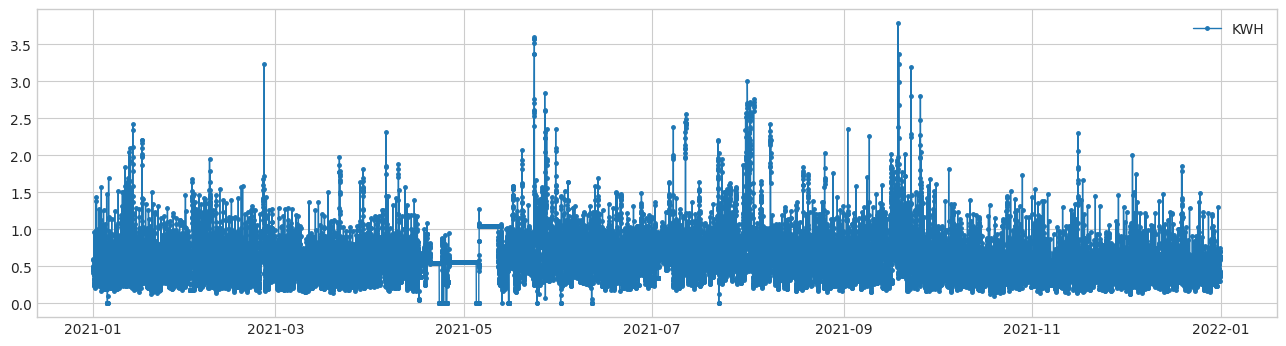

In [5]:
from adtk.visualization import plot
plot(s, ts_linewidth=1, ts_markersize=5);

## Outlier Detection

Ignoring temporal relatioship between data points, identify points that are anomalous.

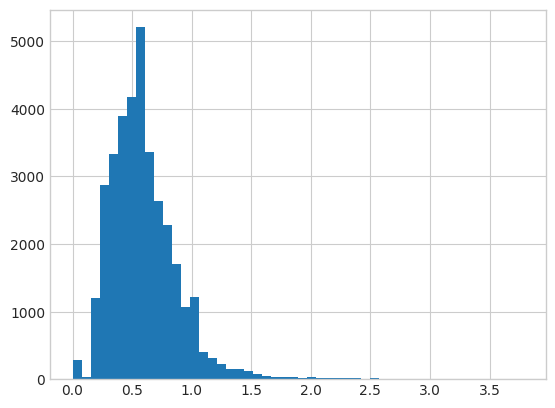

In [6]:
plt.hist(s, bins=50);

### adtk.detector.ThresholdAD

`ThresholdAD` compares each time series value with given thresholds.

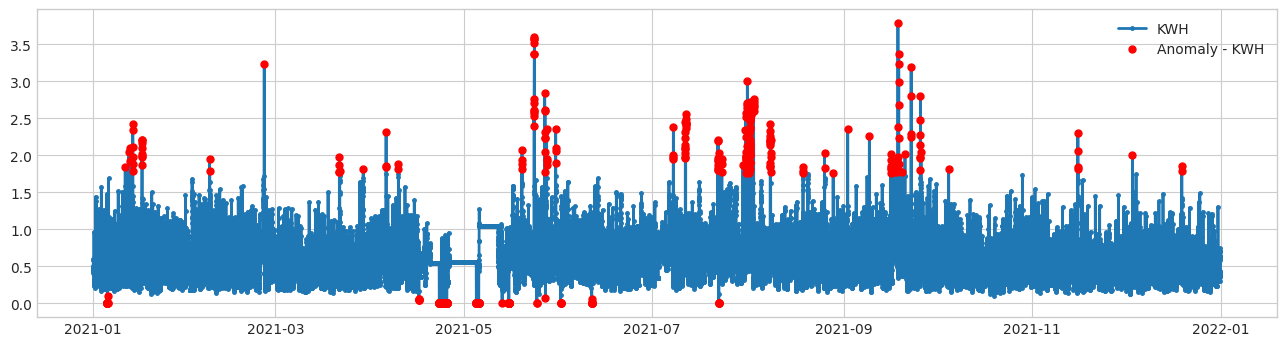

In [7]:
from adtk.detector import ThresholdAD
threshold_ad = ThresholdAD(high=1.75, low=0.1)
anomalies = threshold_ad.detect(s)
plot(s,
     anomaly=anomalies,
     ts_linewidth=2,
     ts_markersize=5,
     anomaly_markersize=5,
     anomaly_color='red',
     anomaly_tag='marker');

In [8]:
print(f"The number of anomalies events are: ", len(anomalies[anomalies['KWH']==True]))

The number of anomalies events are:  528


In [9]:
anomalies = threshold_ad.detect(s, return_list=True)
# anomalies

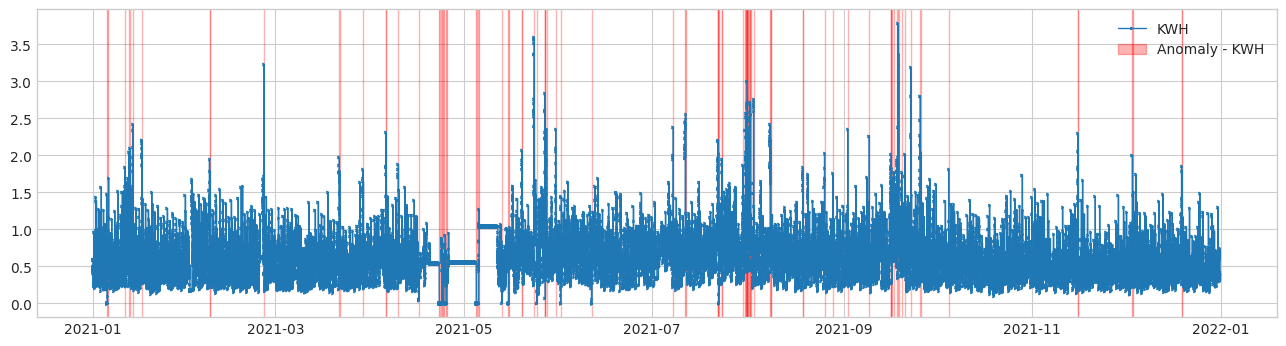

In [10]:
plot(s, anomaly=anomalies, ts_linewidth=1, ts_marker=5, anomaly_color='red');

### adtk.detector.QuantileAD

`QuantileAD` compares each time series value with historical quanties.

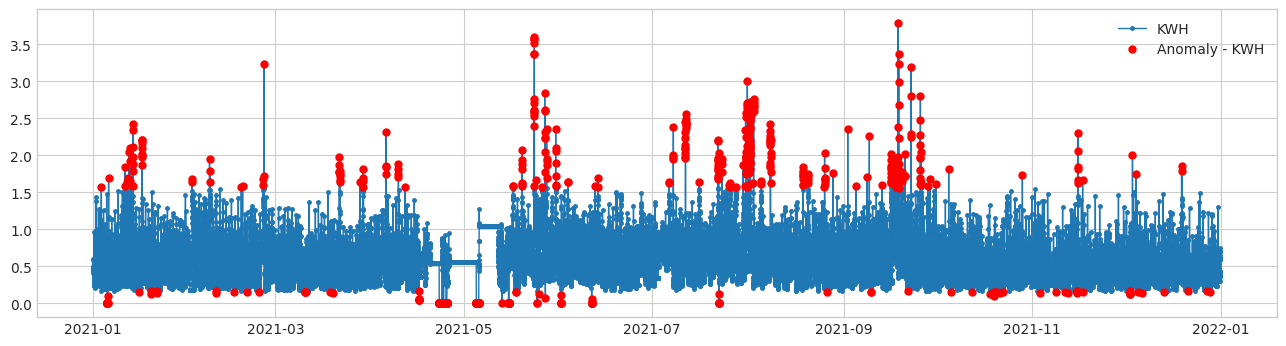

In [11]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)
plot(s,
     anomaly=anomalies,
     ts_linewidth=1,
     ts_markersize=5,
     anomaly_markersize=5,
     anomaly_color='red',
     anomaly_tag='marker');

In [12]:
print(f"The number of anomalies events are: ", len(anomalies[anomalies['KWH']==True]))

The number of anomalies events are:  697


### adtk.detector.InterQuartileRangeAD

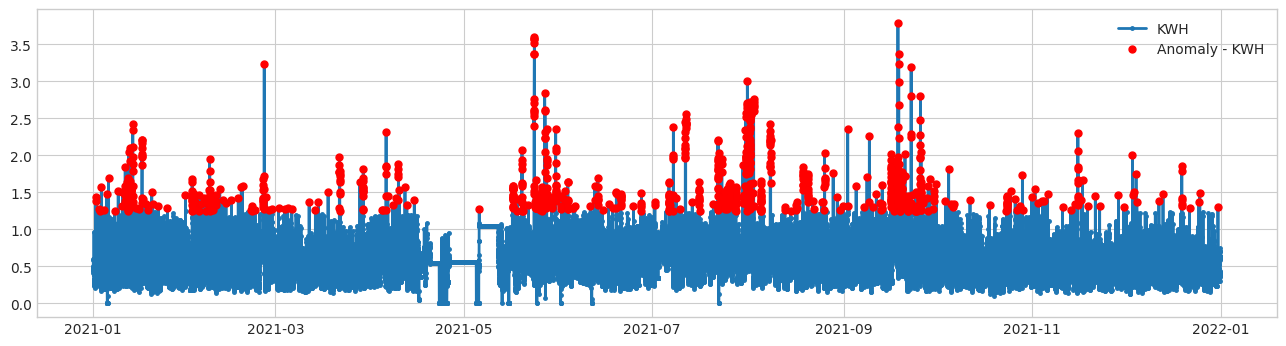

In [13]:
from adtk.detector import InterQuartileRangeAD
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)
plot(s,
     anomaly=anomalies,
     ts_linewidth=2,
     ts_markersize=5,
     anomaly_markersize=5,
     anomaly_color='red',
     anomaly_tag='marker');

In [14]:
print(f"The number of anomalies events are: ", len(anomalies[anomalies['KWH']==True]))

The number of anomalies events are:  938


### adtk.detector.GeneralizedESDTestAD

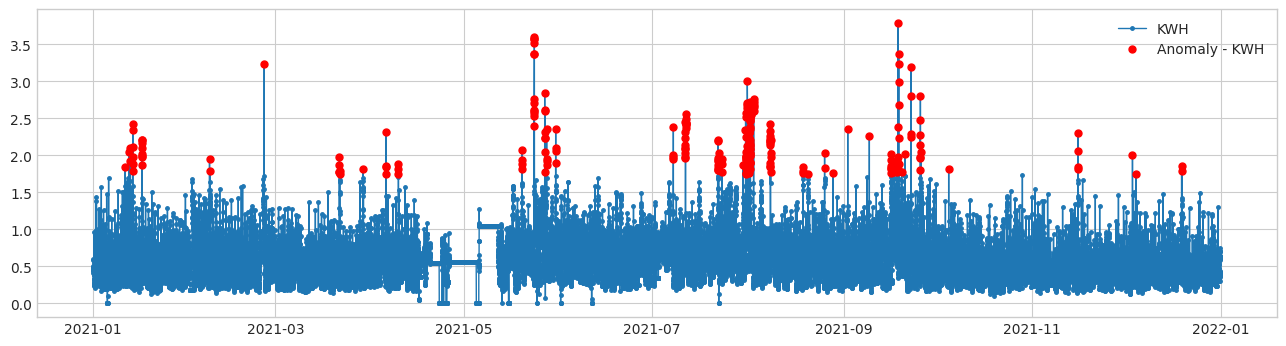

In [15]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=0.3)
anomalies = esd_ad.fit_detect(s)
plot(s,
     anomaly=anomalies,
     ts_linewidth=1,
     ts_markersize=5,
     anomaly_markersize=5,
     anomaly_color='red',
     anomaly_tag='marker');

In [16]:
print(f"The number of anomalies events are: ", len(anomalies[anomalies['KWH']==True]))

The number of anomalies events are:  246


## Anomalous Temporal Behavior

### adtk.detector.PersisAD

`PersistAD` compares each time series value with its previous values. Internally, it is implemented as a `pipenet` with transformer `DoubleRollingAggregate`.


In the following example, we detect anomalous positive changes of price.

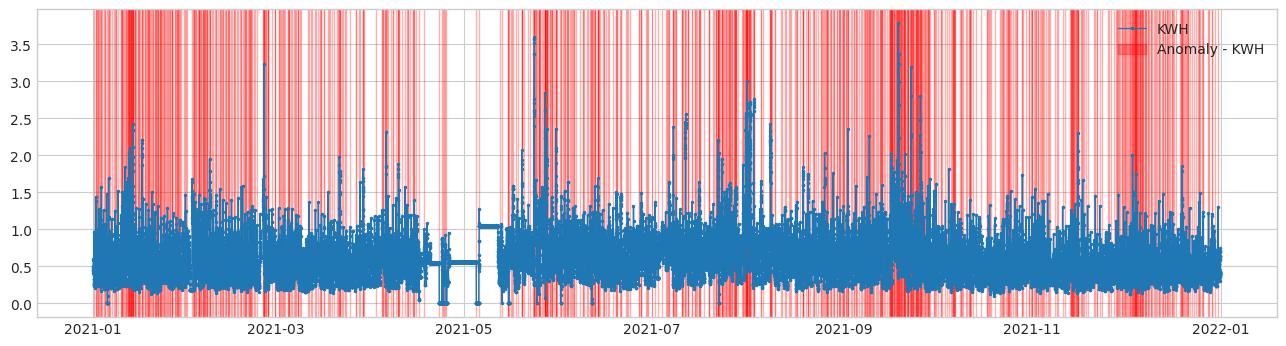

In [17]:
from adtk.detector import PersistAD
persist_ad = PersistAD(c=3.0, side='both')
anomalies = persist_ad.fit_detect(s)
plot(s,
     anomaly=anomalies,
     ts_linewidth=1,
     ts_markersize=3,
     anomaly_color='red');

### adtk.transformer.DoubleRollingAggregate

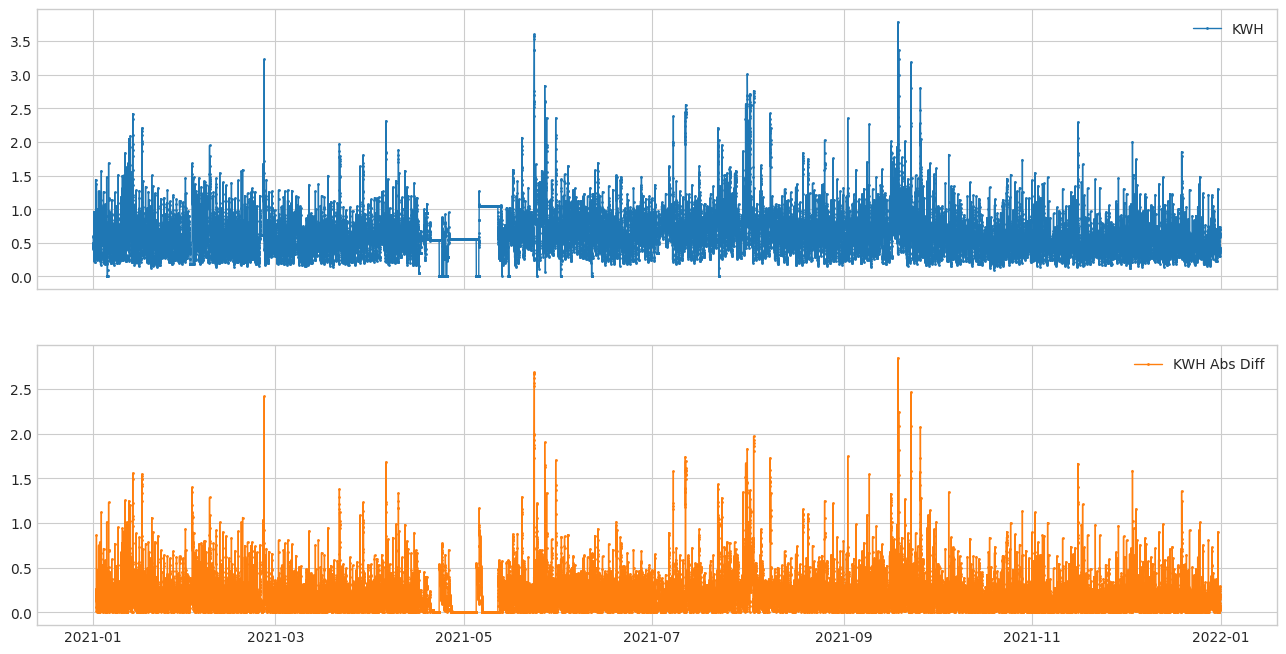

In [30]:
from adtk.transformer import DoubleRollingAggregate
dra_tf = DoubleRollingAggregate(agg='mean', window=(96, 1), center=True, diff='l1')
s_transformed = dra_tf.transform(s).rename(columns={"KWH":"KWH Abs Diff"})
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1);

In [31]:
s_transformed

,KWH Abs Diff
DATE-Time,
2021-01-01 00:00:00,NaN
2021-01-01 00:15:00,NaN
2021-01-01 00:30:00,NaN
2021-01-01 00:45:00,NaN
2021-01-01 01:00:00,NaN
...,...
2021-12-31 22:45:00,0.051510
2021-12-31 23:00:00,0.107417
2021-12-31 23:15:00,0.150812


### adtk.detector.SeasonalAD

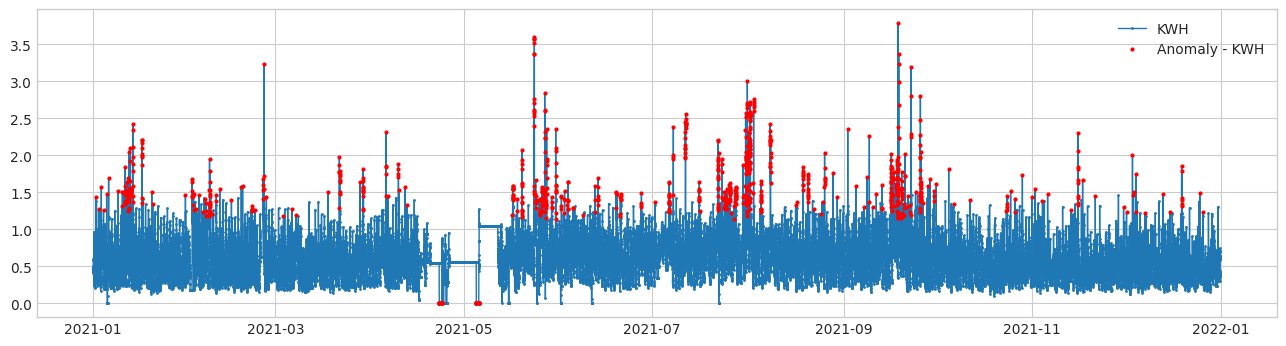

In [34]:
from adtk.detector import SeasonalAD
seasonal_ad = SeasonalAD(c=3.0, side='both')
anomalies = seasonal_ad.fit_detect(s)
plot(s,
    anomaly=anomalies,
    ts_linewidth=1,
    anomaly_color='red',
    anomaly_tag='marker',
    anomaly_markersize=2);

In [35]:
print(f"The number of anomalies events are: ", len(anomalies[anomalies['KWH']==True]))

The number of anomalies events are:  820


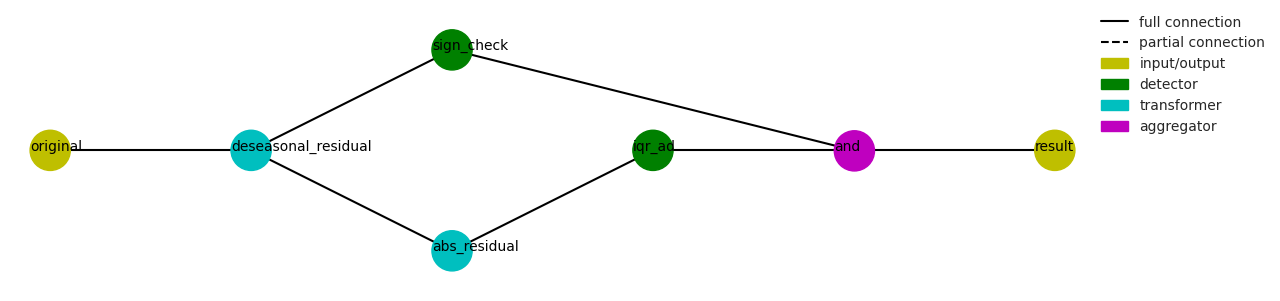

In [39]:
seasonal_ad.pipe_.plot_flowchart();

### adtk.tranformer.ClassicSeasonalDecomposition

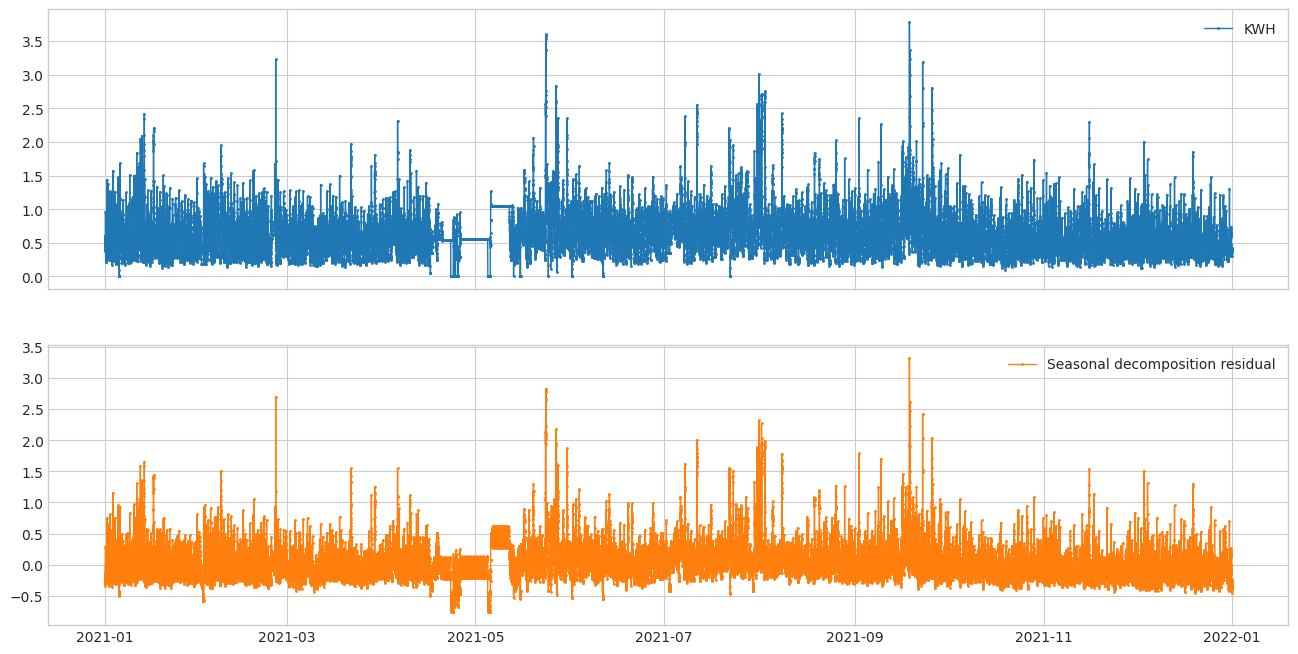

In [41]:
from adtk.transformer import ClassicSeasonalDecomposition
seasonal_tf = ClassicSeasonalDecomposition()
s_transformed = seasonal_tf.fit_transform(s).rename(columns={"KWH":'Seasonal decomposition residual'})
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1);

### adta.data.split_train_test

When building a time series anomaly detection model, splitting a historical series into training and testing segments is a common operation needed.

Function `split_train_test` provides four modes of splitting. A user may choose from it according to the specific case.

1. Divide time series into n_splits folds of equal length, split each fold into training and testing based on train_ratio.

2. Create n_splits folds, where each fold starts at t_0 and ends at t_(n/n_splits), where n goes from 0 to n_splits and the first train_ratio of the fold is for training.

3. Create n_splits folds, where each fold starts at t_0. Each fold has len(ts)/(1 + n_splits) test points at the end. Each fold is n * len(ts)/(1 + n_splits) long, where n ranges from 1 to n_splits.

4. Create n_splits folds, where each fold starts at t_0. Each fold has n * len(ts)/(1 + n_splits) training points at the beginning of the time series, where n ranges from 1 to n_splits and the remaining points are testing points.

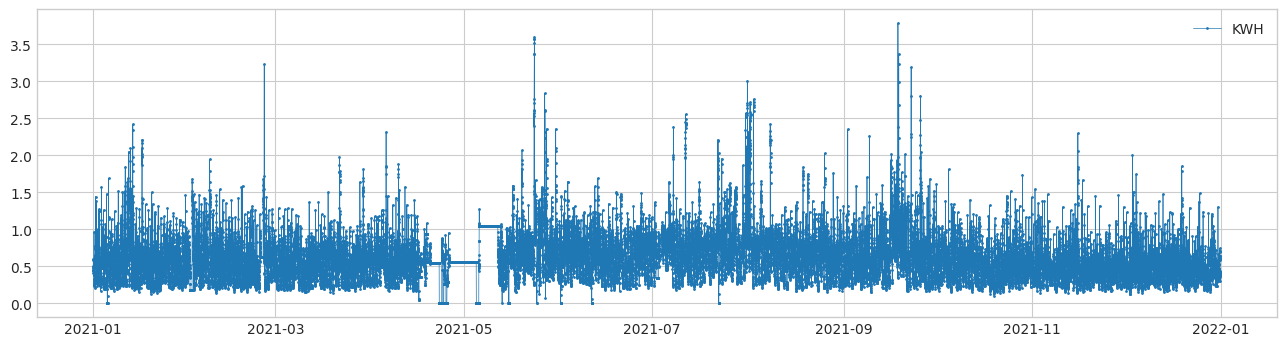

In [44]:
plot(s);

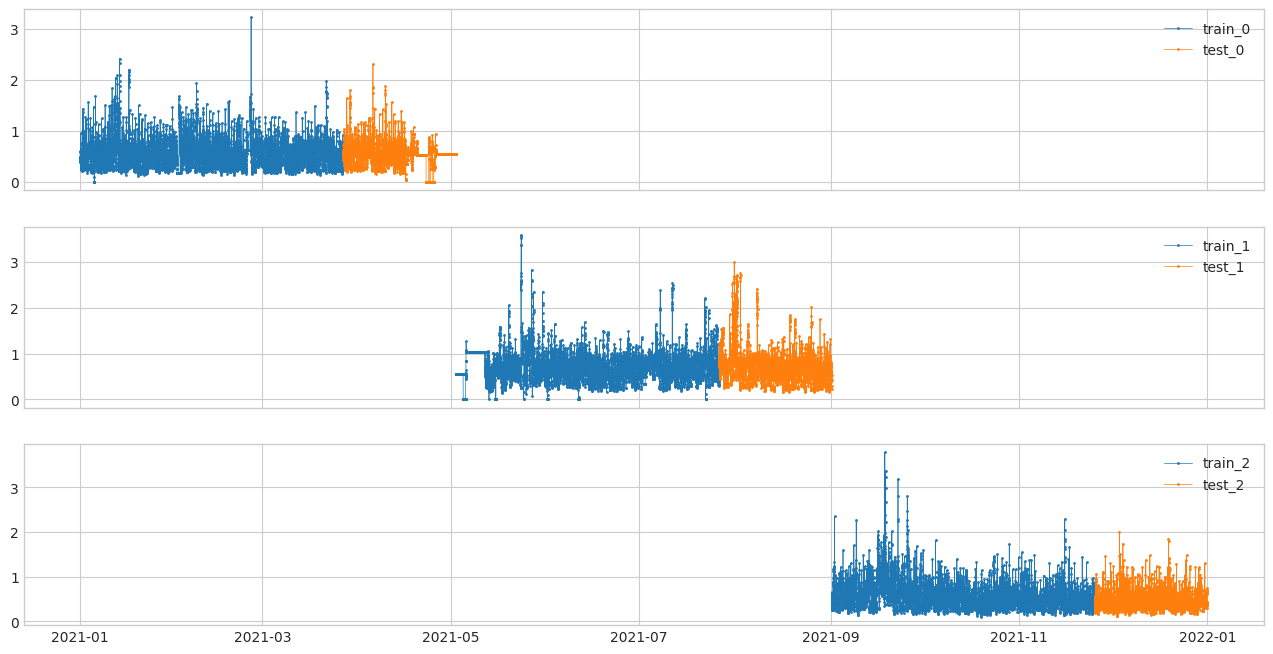

In [45]:
# Mode 1
from adtk.data import split_train_test
splits = split_train_test(s, mode=1, n_splits=3, train_ratio=0.7)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df, 
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

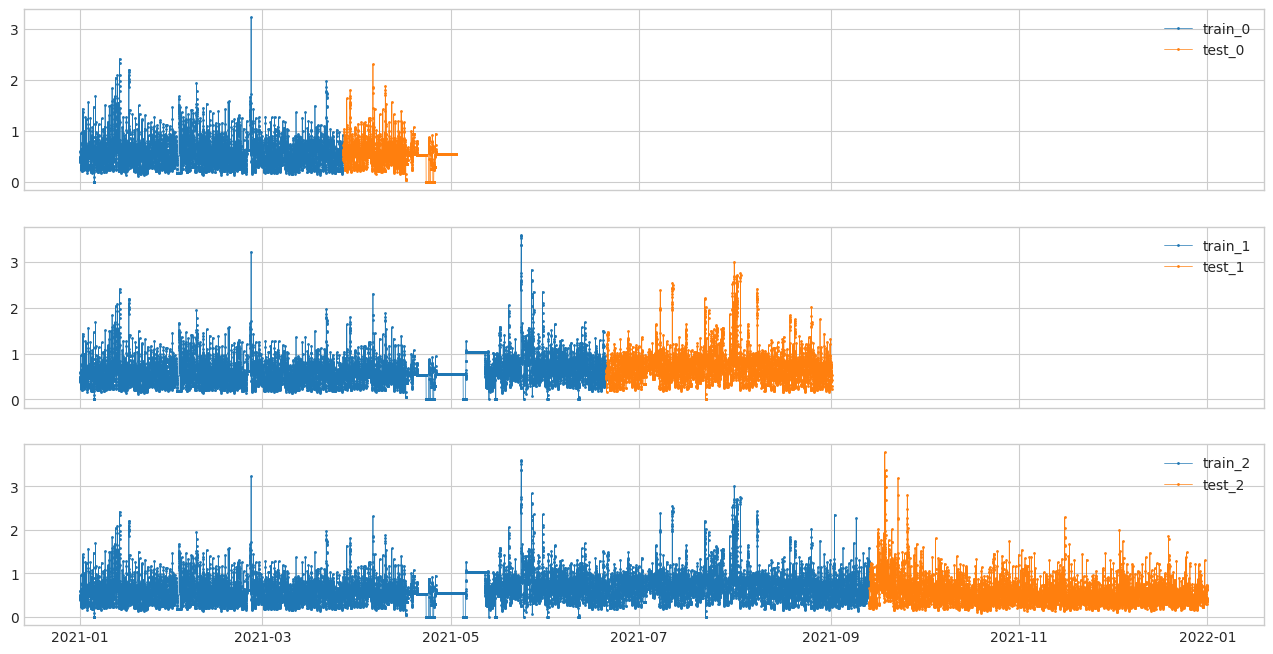

In [46]:
# Mode 2
splits = split_train_test(s, mode=2, n_splits=3, train_ratio=0.7)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df, 
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

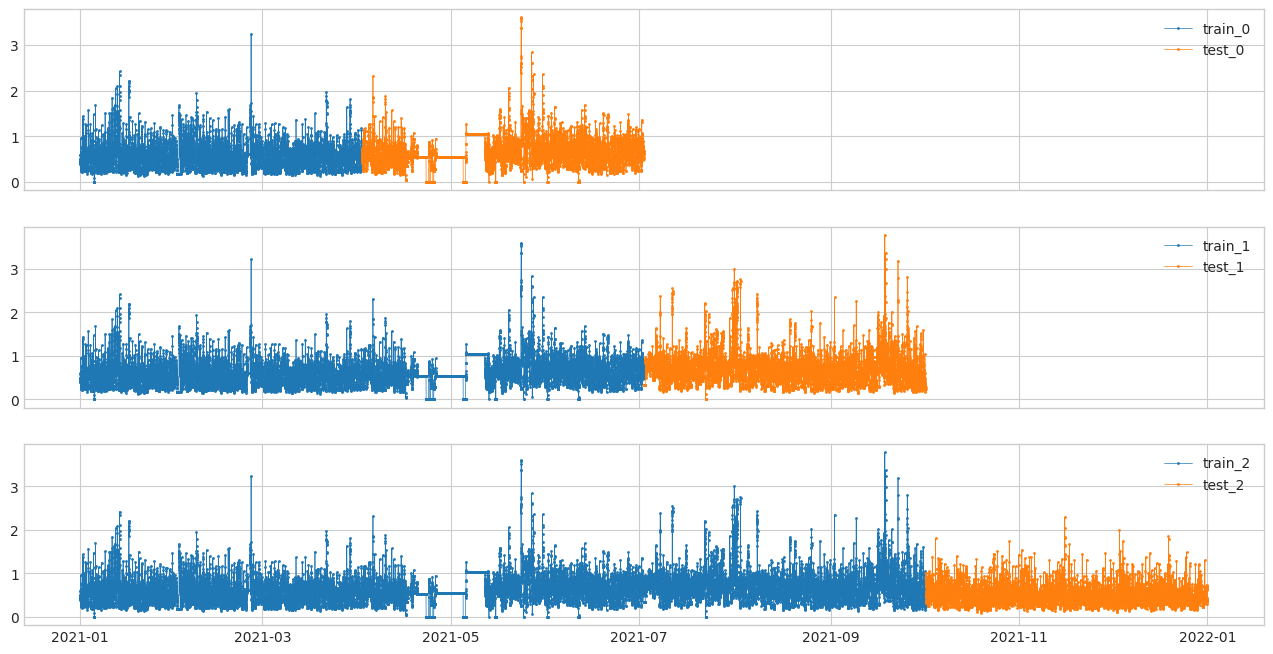

In [47]:
# Mode 3
splits = split_train_test(s, mode=3, n_splits=3)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df, 
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));

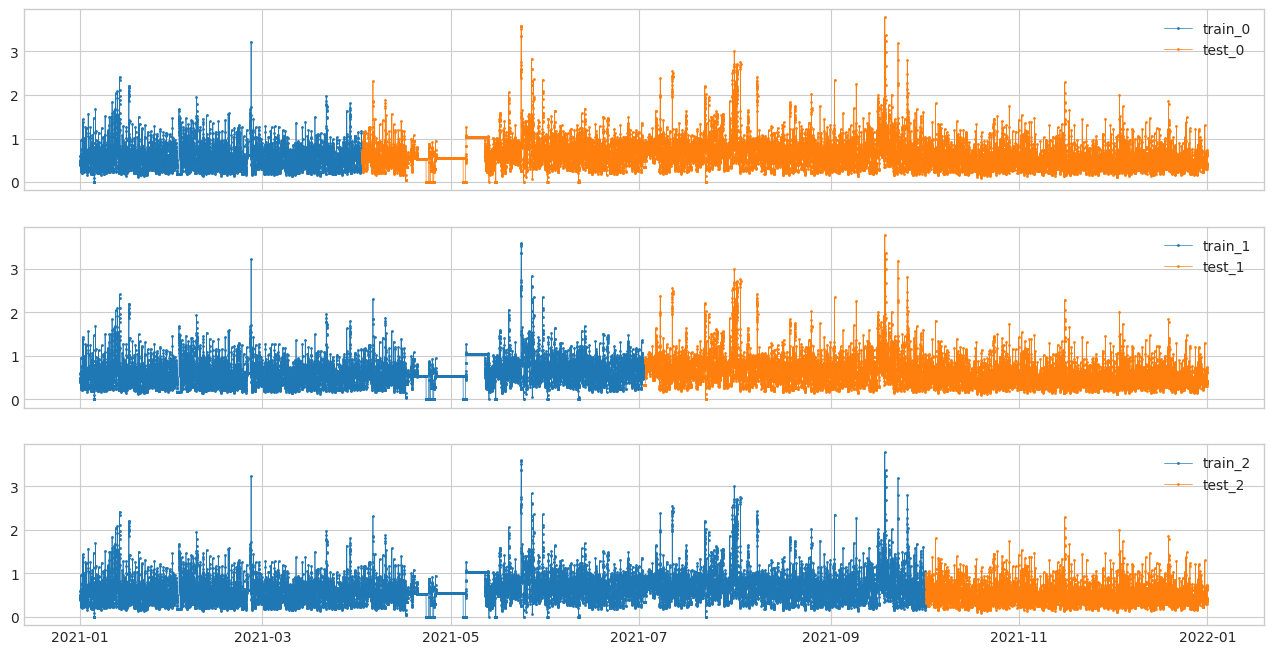

In [48]:
# Mode 4
splits = split_train_test(s, mode=4, n_splits=3)
df = pd.DataFrame(index=s.index)
for i, (train, test) in enumerate(splits):
    df["train_{}".format(i)] = train
    df["test_{}".format(i)] = test
plot(df, 
     curve_group=[("train_{}".format(i), "test_{}".format(i)) for i in range(3)],
     ts_color={**{"train_{}".format(i): "tab:blue" for i in range(3)}, **{"test_{}".format(i): "tab:orange" for i in range(3)}},
     figsize=(16, 8));